In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

In [ ]:
def plot_learning_curve(loss_values, loss_test_values):
  fig, ax = plt.subplots()
  ax.plot(loss_values, 'b', label='train')
  ax.plot(loss_test_values, 'y', label='test')
  legend = ax.legend()

  plt.title('learning curve')
  plt.xlabel('steps')
  plt.ylabel('loss')
  plt.show()

In [ ]:
class ConvLayer(nn.Module):
  def __init__(self, input_ch, output_ch, kernel_size=3, stride=1, padding=1):
    super().__init__()
    self.conv = nn.Conv2d(input_ch, output_ch, kernel_size, stride, padding)
    self.batch_norm = nn.BatchNorm2d(output_ch)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    x = self.conv(x)
    x = self.batch_norm(x)
    x = self.relu(x)
    return x

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, input_ch, output_ch):
    super().__init__()
    self.conv1 = ConvLayer(input_ch, output_ch, kernel_size=3, stride=1, padding=1) #Дописать kernel_size, stirde, padding
    self.conv2 = ConvLayer(output_ch, output_ch, kernel_size=3, stride=1, padding=1) #Дописать kernel_size, stirde, padding

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    x = self.conv1(x)

    return out + x

In [ ]:
class MyResNet(nn.Module):
  def __init__(self, input_ch, output_dim):
    super().__init__()
    self.conv1 = ConvLayer(input_ch, 64, kernel_size=3, stride=1, padding=1) 
    self.conv2 = ConvLayer(64, 128, kernel_size=4, stride=2, padding=1)
    self.res1 = ResBlock(128, 128) 
    self.conv3 = ConvLayer(128, 256, kernel_size=4, stride=2, padding=1) 
    self.conv4 = ConvLayer(256, 256, kernel_size=4, stride=2, padding=1) 
    self.res2 = ResBlock(256, 512)
    self.classifier = nn.Sequential(nn.AvgPool2d(kernel_size=6, padding=1, stride=1),
                                    nn.Flatten(),
                                    nn.Linear(512, output_dim))
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.res1(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.res2(x)
    x = self.classifier(x)

    return x


In [ ]:
class ResNet:
  def __init__(self):
    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    self.use_cuda = torch.cuda.is_available()
    self.net = MyResNet(3, 10).to(self.device) if self.use_cuda else MyResNet(3, 10)
    self.optimizer = None
    self.train_losses = []
    self.test_losses = []
    self.start_epoch = 1
    self.flag_train = False
    self.flag_test = False

  def train(self, save_dir, num_epochs, batch_size, learning_rate):
    if self.flag_train == False:
      train_transform = transforms.Compose([
              transforms.RandomCrop(32, padding=4),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
          ])
      
      train_dataset = torchvision.datasets.CIFAR10('data/cifar', 
                                              train=True, 
                                              download=True, 
                                              transform=train_transform)
      
      data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      self.flag_train == True

    self.optimizer = torch.optim.Adam(self.net.parameters(), lr=learning_rate, weight_decay=1e-5)

    criterion = nn.CrossEntropyLoss().to(self.device) if self.use_cuda else torch.nn.CrossEntropyLoss()

    self.net.train()

    for epoch in range(self.start_epoch, num_epochs + 1):
      print('Epoch {}/{}'.format(epoch, num_epochs))
      epoch_correct = 0
      epoch_total = 0

      epoch_loss = 0.0
      total_steps = 0
      for i, data in enumerate(data_loader, 1):
          images, labels = data
          images = images.to(self.device)
          labels = labels.to(self.device)

          self.optimizer.zero_grad()
          outputs = self.net.forward(images)
          loss = criterion(outputs, labels.squeeze_())
          loss.backward()
          self.optimizer.step()

          epoch_loss += loss.item()
          total_steps += 1

          _, predicted = torch.max(outputs.data, dim=1)
          batch_total = labels.size(0)
          batch_correct = (predicted == labels.flatten()).sum().item()

          epoch_total += batch_total
          epoch_correct += batch_correct

      self.train_losses.append(epoch_loss / total_steps)
      print('Train loss: {}'.format(epoch_loss / total_steps))
      print('Train accuracy: %d %%'% (100.0 * epoch_correct / epoch_total))

      
      test_loss, test_accuracy = self.test()
      self.test_losses.append(test_loss)
      print('Test loss: {}'.format(test_loss))
      print('Test accuracy: %d %%' % (test_accuracy * 100.0))

      # Save parameters after every epoch
      self.save_parameters(epoch, directory=save_dir)

  def test(self, batch_size=256):
    if self.flag_test == False:
      test_transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                            ])

      test_dataset = torchvision.datasets.CIFAR10('data/cifar', 
                                                  train=False, 
                                                  download=True, 
                                                  transform=test_transform)

      data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

      self.flag_test == True

    criterion = nn.CrossEntropyLoss().to(self.device) if self.use_cuda else torch.nn.CrossEntropyLoss()

    self.net.eval()

    correct = 0
    total = 0
    epoch_loss = 0.0
    total_steps = 0
    with torch.no_grad():
      for i, data in enumerate(data_loader, 0):
          images, labels = data
          images = images.to(self.device)
          labels = labels.to(self.device)

          outputs = self.net(images)
          _, predicted = torch.max(outputs, dim=1)
          total += labels.size(0)
          correct += (predicted == labels.flatten()).sum().item()

          loss = criterion(outputs, labels.squeeze_())
          epoch_loss += loss.item()
          total_steps += 1

    self.net.train()
    return (epoch_loss / total_steps, correct / total)

  def save_parameters(self, epoch, directory):
    if not os.path.exists(directory):
      os.makedirs(directory)
    torch.save({
        'epoch': epoch,
        'model_state_dict': self.net.state_dict(),
        'optimizer_state_dict': self.optimizer.state_dict(),
        'train_accuracies': self.train_losses,
        'test_accuracies': self.test_losses
    }, os.path.join(directory, 'resnet_' + str(epoch) + '.pth'))

  def load_parameters(self, path):
    self.optimizer = torch.optim.Adam(self.net.parameters())
    checkpoint = torch.load(path, map_location=self.device)
    self.net.load_state_dict(checkpoint['model_state_dict'])
    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    self.train_accuracies = checkpoint['train_accuracies']
    self.test_accuracies = checkpoint['test_accuracies']
    self.start_epoch = checkpoint['epoch']


In [ ]:
resnet = ResNet()

In [ ]:
resnet.train(save_dir='saves', num_epochs=75, batch_size=256, learning_rate=0.001)

Files already downloaded and verified
Epoch 1/75
Train loss: 1.4747620930477066
Train accuracy: 44 %
Files already downloaded and verified
Test loss: 1.223727223277092
Test accuracy: 55 %
Epoch 2/75
Train loss: 1.0073606648615427
Train accuracy: 63 %
Files already downloaded and verified
Test loss: 1.0617091685533524
Test accuracy: 62 %
Epoch 3/75
Train loss: 0.8206214174932364
Train accuracy: 70 %
Files already downloaded and verified
Test loss: 0.8880273759365082
Test accuracy: 69 %
Epoch 4/75
Train loss: 0.6949464508465358
Train accuracy: 75 %
Files already downloaded and verified
Test loss: 0.8738016992807388
Test accuracy: 70 %
Epoch 5/75
Train loss: 0.6111761869824662
Train accuracy: 78 %
Files already downloaded and verified
Test loss: 0.6187248736619949
Test accuracy: 78 %
Epoch 6/75
Train loss: 0.5472707961286817
Train accuracy: 80 %
Files already downloaded and verified
Test loss: 0.5927618071436882
Test accuracy: 79 %
Epoch 7/75
Train loss: 0.49998422651266566
Train accuracy

## Learning Curve

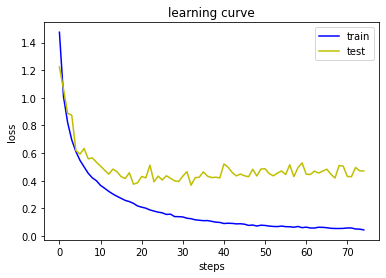

In [ ]:
plot_learning_curve(resnet.train_losses, resnet.test_losses)

## Load train model

In [ ]:
resnet = ResNet()
resnet.load_parameters(path='saves/resnet_74.pth')
_, accuracy = resnet.test()
print('accuracy = %d %%'% (100.0 * accuracy))

Files already downloaded and verified
accuracy = 90 %
